In [2]:
# Import statements

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import cv2
from skimage.transform import warp

#ipython setting
rcParams['figure.figsize'] = (20, 12)

$\newcommand{\vecl}[1]{\begin{pmatrix}#1\end{pmatrix}}$ 
$\newcommand{\hvec}[1]{\widetilde{\boldsymbol{#1}}}$
$\newcommand{\nvec}[1]{\boldsymbol{#1}}$

## Header

--Text--

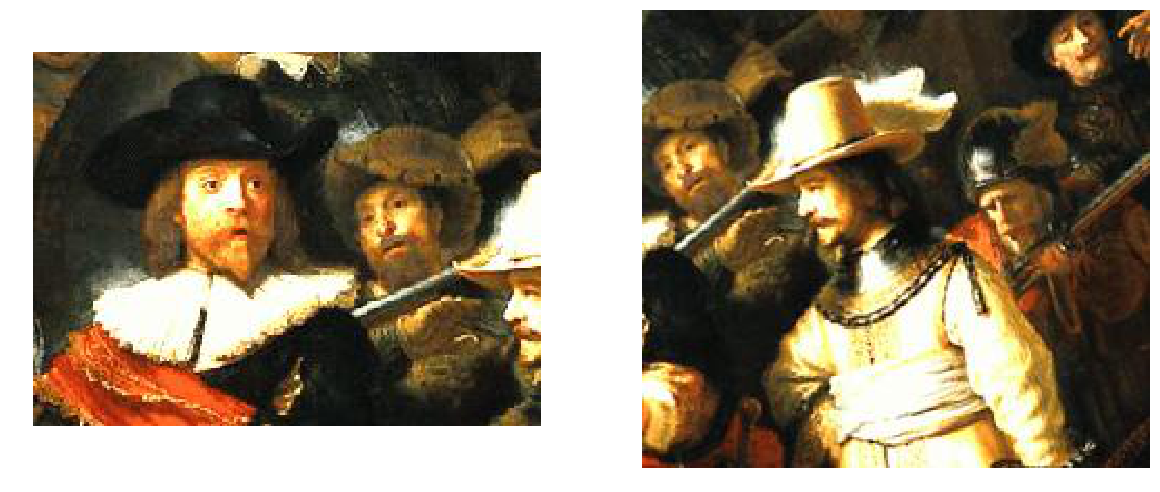

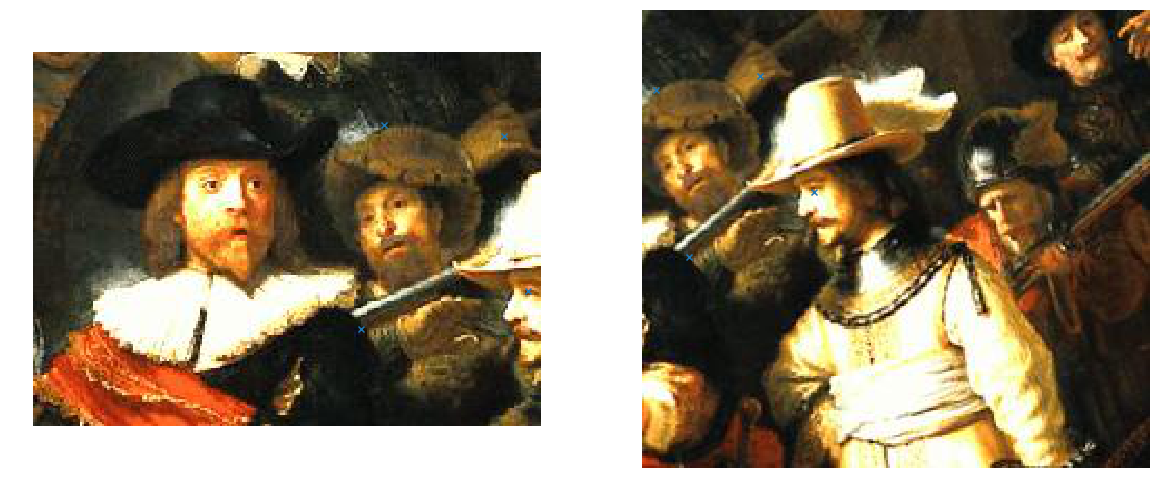

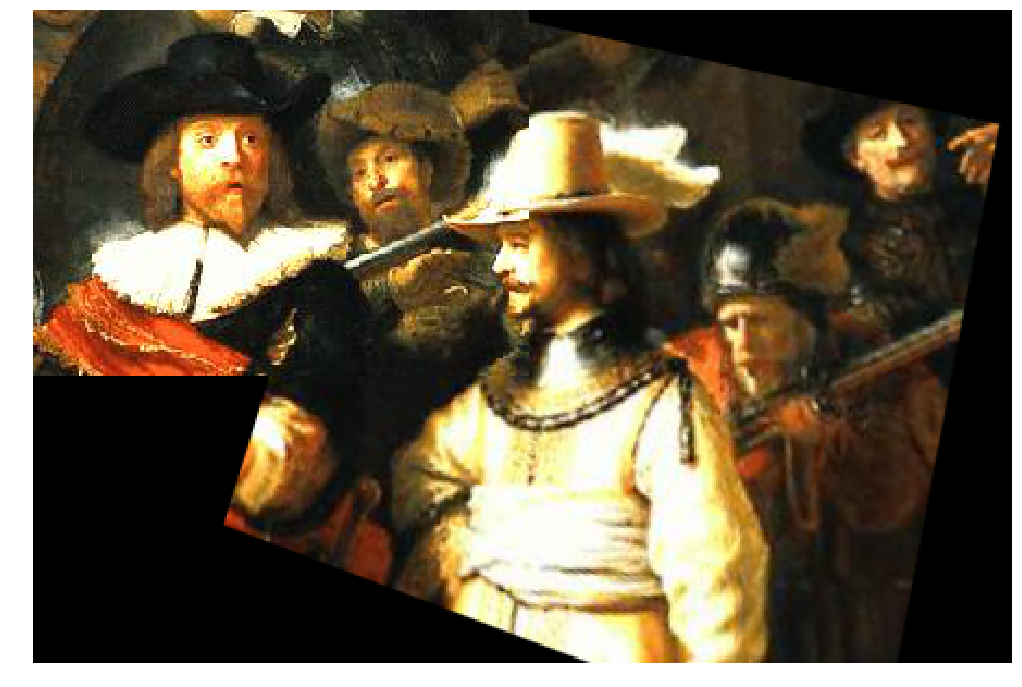

In [44]:
f1 = plt.imread('nachtwacht1.jpg')/255
plt.subplot(121); plt.imshow(f1); plt.axis('off')

f2 = plt.imread('nachtwacht2.jpg')/255
plt.subplot(122); plt.imshow(f2); plt.axis('off')

plt.show()

# Points in the left image
xy = np.array([[ 157, 32],
               [ 211, 37],
               [ 222,107],
               [ 147,124]])


# Points in right image:
xaya = np.array([[  6, 38],
                 [ 56, 31],
                 [ 82, 87],
                 [ 22,118]])


plt.subplot(121); plt.imshow(f1); plt.axis('off');
plt.scatter(xy[:,0], xy[:,1], marker='x');
plt.subplot(122); plt.imshow(f2); plt.axis('off');
plt.scatter(xaya[:,0], xaya[:,1], marker='x');
plt.show()


P = perspectiveTransform(xy.astype(np.float32), xaya.astype(np.float32))

f_stitched = warp(f2, P, output_shape=(300,450))

M, N = f1.shape[:2]

f_stitched[0:M, 0:N, :] = f1

plt.imshow(f_stitched)
plt.axis('off')
plt.show()

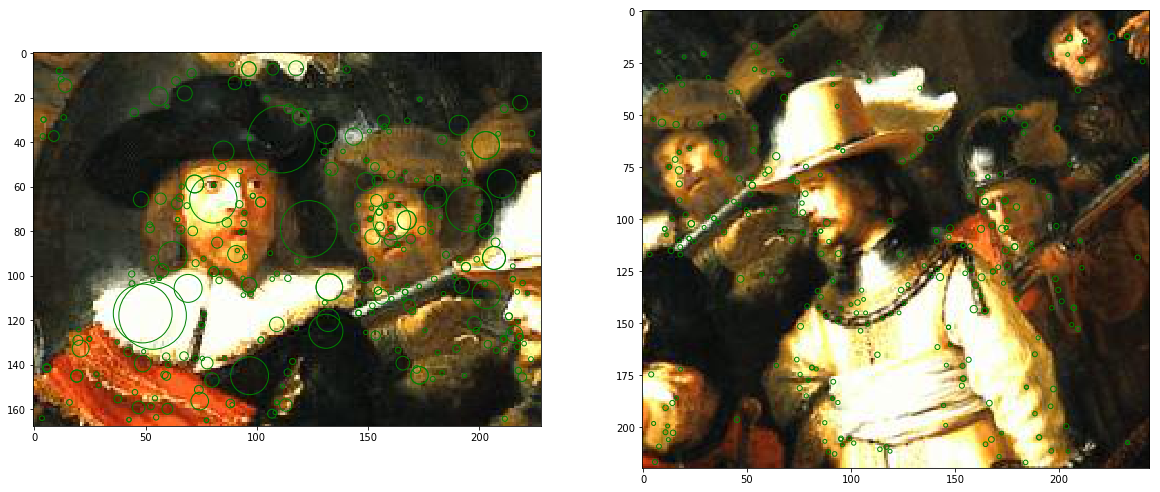

309
478
309


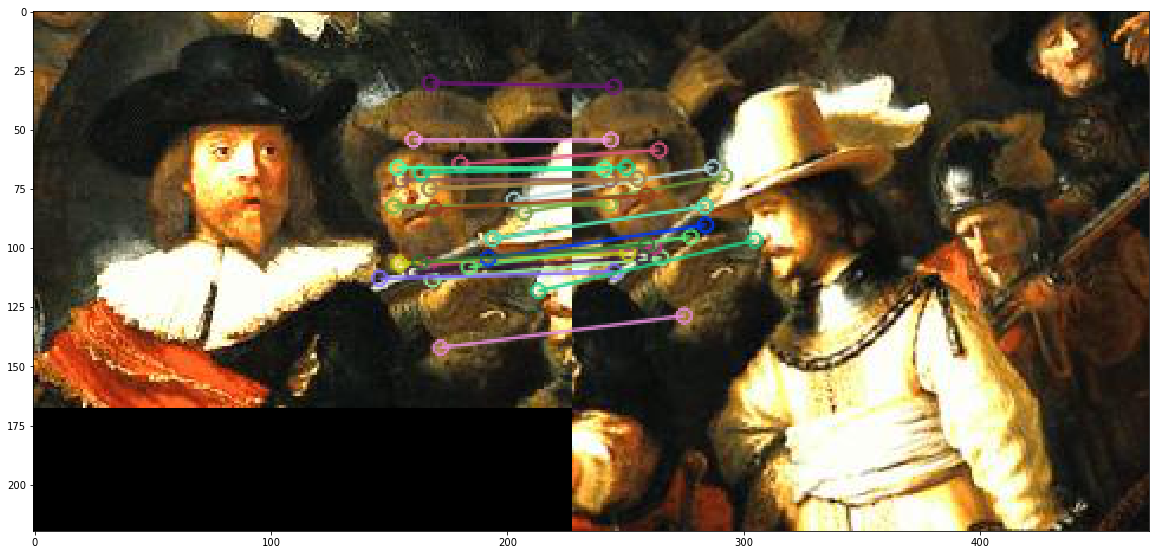

In [99]:
import cv2

f1 = plt.imread('nachtwacht1.jpg')
f2 = plt.imread('nachtwacht2.jpg')

f1cv2 = f1[:,:,::-1] # OpenCV uses BGR ordering of color channels
f2cv2 = f2[:,:,::-1] # OpenCV uses BGR ordering of color channels
fig, axes = plt.subplots(1, 2)
axes[0].imshow(f1)
axes[1].imshow(f2)
sift = cv2.xfeatures2d.SIFT_create()
kps1, dscs1 = sift.detectAndCompute(f1cv2, mask=None)
kps2, dscs2 = sift.detectAndCompute(f2cv2, mask=None)

for kp1, kp2 in zip(kps1, kps2):
    axes[0].add_artist(plt.Circle((kp1.pt), kp1.size/2, color='green', fill=False))
    axes[1].add_artist(plt.Circle((kp2.pt), kp2.size/2, color='green', fill=False))

plt.show()

matcher = cv2.BFMatcher()
matches = matcher.match(dscs1,dscs2)
matches = sorted(matches, key = lambda x:x.distance)

print(len(kps1))
print(len(kps2))
print(len(matches))
matches_img = cv2.drawMatches(f1,kps1,f2,kps2,matches[:25], None, flags=2)
plt.imshow(matches_img)
plt.show()

In [100]:
def perspectiveTransform(p1, p2):
    
    M = np.array([[p1[int(n/2)][0], p1[int(n/2)][1], 1, 0, 0, 0, -p1[int(n/2)][0] * p2[int(n/2)][0], -p2[int(n/2)][0] * p1[int(n/2)][1], -p2[int(n/2)][0]] if n % 2 == 0 else
                  [0, 0, 0, p1[int(n/2)][0], p1[int(n/2)][1], 1, -p1[int(n/2)][0] * p2[int(n/2)][1], -p2[int(n/2)][1] * p1[int(n/2)][1], -p2[int(n/2)][1]] for n in range(2 * len(p1))])

    U, D, V_t = np.linalg.svd(M)
    # Taking the last row of V_t (same as last column of V) and reshape to 3x3 matrix
    return V_t[-1].reshape((3, 3))

perspectiveTransform([(1,1), (1, 2)], [(1, 3), (2, 6)])

array([[ 0.29111632,  0.0011691 , -0.05140594],
       [ 0.55268501,  0.00350729,  0.16644613],
       [-0.31963267, -0.11985519,  0.68036733]])

RANSAC

1. Get keypoints
2. Pick n random keypoints
3. Calculate projective transform matrix
4. Apply transform on all keypoints
5. Check Euclidian distance from transformed keypoints to actual keypoints
6. Apply error norm
7. Choose to keep or reject projective transform matrix based on error and previous best
8. Repeat


SUBSECTIONS

SIFT
Matching
Ransac
Perspective transform

In [125]:
from numpy.random import randint

import numpy as np
from sklearn.model_selection import train_test_split
X, y = np.arange(10).reshape((5, 2)), range(5)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)

def keypointRandomizeSelect(matches, n):
    
    # Take n random items from 'matches' 
    test_size = 1 - n/len(matches)
    return train_test_split(matches, test_size=test_size)
    
    
def findDistance(p1, p2, threshold):
    
    # Calculate the amount of points that are within the threshold value
    return np.linalg.norm(a-b) for (a, b) in zip(p1, p2) if np.linalg.norm(a-b) < threshold
    
keypointRandomizeSelect([1, 2, 3, 4, 5], 3)

SyntaxError: invalid syntax (<ipython-input-125-5733dc72b186>, line 19)

[array([-0.42814205, -0.50075995, -0.00318723]), array([ 0.06309637,  0.09638815,  0.00064711]), array([ -2.20146600e-02,  -1.50846305e-02,  -2.77059422e-06]), array([-0.237503  , -0.26894777, -0.00169934])]
0


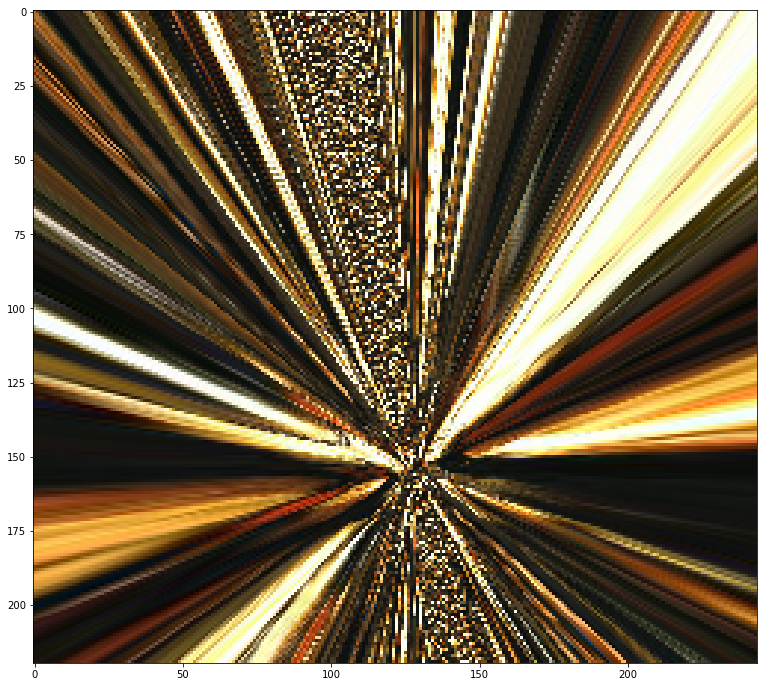

In [124]:
from skimage.transform import warp
from sys import maxsize


def RANSAC(kps1, kps2, matches, fitfunc, errorfunc, selectionfunc,
           numIterations=1, numPoints=4, threshold=3):
    
    # Save all actual points from keypoint descriptors as homogeneous coordinates
    kps1_hc = [np.hstack((kp.pt, [1])) for kp in kps1]
    kps2_hc = [np.hstack((kp.pt, [1])) for kp in kps2]
    
    # RANSAC setup values
    bestFit = None
    bestErr = maxsize
    
    for i in range(numIterations):
        
        # Select keypoints
        maybeIn, rest = selectionfunc(matches, numPoints)
        p1 = [kps1_hc[keypoint.queryIdx] for keypoint in maybeIn]
        p2 = [kps2_hc[keypoint.trainIdx] for keypoint in maybeIn]
        # Calculate perspective transform matrix
        p = fitfunc(p1, p2)
        # Transform points from first image using calculated matrix
        calculated = [np.dot(p, kps1_hc[keypoint.queryIdx]) for keypoint in rest]
        
        
        print(calculated)
        
        
        # Calculate euclidian distance between points calculated and points gotten
        error = errorfunc(kps2_hc, calculated, threshold)
        
        if error < bestErr:
            bestFit = p
            bestErr = error
            
    return bestFit, bestErr

    
    
p, err = RANSAC(kps1, kps2, matches, perspectiveTransform, findDistance, keypointRandomizeSelect)
print(err)
plt.imshow(warp(f2, np.linalg.inv(p), order=3, mode='reflect'))
plt.show()

# TODO: REDO RANSAC problem mostly in error calculation, because it needs indices of corresponding keypoints 
# of testing data.
    